In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

In [3]:
data = pd.read_excel('/private/wuchenpeng/projects/high-molecular/data/dup_log.xlsx')


In [4]:
adata = data[['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', '[n]', '转化率（%）']]
adata

,redox,azo,fe,ybc,温度,浓度,AMPS,[n],转化率（%）
0,5.000000,5.000000,0.0,5.000000,0,15,10,0.0,0.0
1,3.958607,3.958607,0.5,3.958607,5,15,10,0.0,0.0
2,2.995679,2.995679,1.0,2.995679,10,15,10,1120.0,71.0
3,1.999566,1.999566,1.5,1.999566,15,15,10,1385.0,80.0
4,0.999957,0.999957,2.0,0.999957,20,15,10,240.0,100.0
...,...,...,...,...,...,...,...,...,...
172,2.995679,2.396856,1.0,5.000000,5,25,50,1925.3,96.8
173,2.995679,2.521434,1.0,5.000000,5,25,50,1902.0,96.3
174,2.995679,2.396856,2.0,5.000000,5,25,75,1705.0,98.2
175,2.995679,2.396856,2.0,5.000000,5,25,100,1386.0,99.9


In [5]:
columns = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', '[n]', '转化率（%）']
# columns_normalize = ['combined_feature', 'combined_feature1', 'combined_feature2']
# columns_to_normalize = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', '[n]', '转化率（%）',
#                         'combined_feature', 'combined_feature1', 'combined_feature2']
data_to_normalize = data[columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
data[columns] = pd.DataFrame(normalized_data, columns=columns)

绘制3D曲线

In [6]:
X_feature = adata['ybc']
Y_feature = adata['azo']
Z_output = adata['[n]']

In [55]:
# 转换为网格数据，适合绘制 3D 曲面
X_unique = np.unique(X_feature)
Y_unique = np.unique(Y_feature)
X, Y = np.meshgrid(X_unique, Y_unique)

In [56]:

# 使用 DataFrame 数据生成 Z
Z = np.zeros_like(X, dtype=float)
for i in range(len(X_unique)):
    for j in range(len(Y_unique)):
        # 根据特征值查找对应的输出值
        value = data[(data['ybc'] == X_unique[i]) & (data['azo'] == Y_unique[j])]['[n]']
        if not value.empty:
            Z[j, i] = value.values[0]

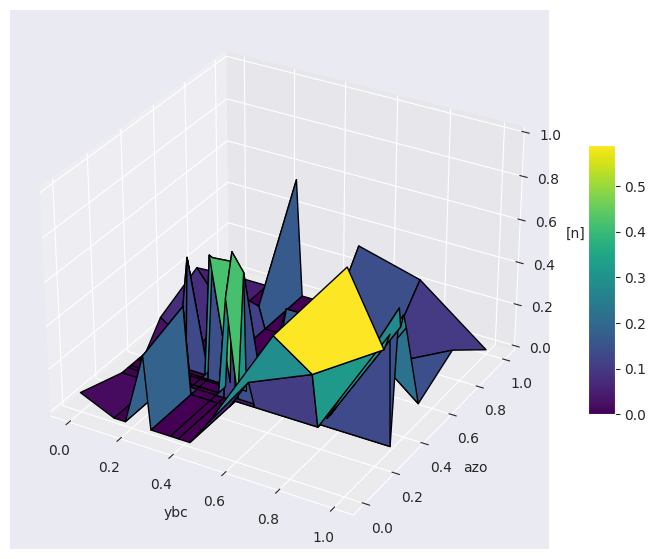

In [57]:
# 绘制 3D 图像
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
surface = ax.plot_surface(X, Y, Z, cmap="viridis", edgecolor="k")

# 添加轴标签
ax.set_xlabel("ybc")
ax.set_ylabel("azo")
ax.set_zlabel("[n]")

# 添加颜色条
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10)

plt.show()

数据分布

In [58]:
# plt.figure(figsize=(12, 6))
# plt.title(f'Original  Distribution')
# for i, column in enumerate(columns, 1):
#     plt.subplot(2, len(columns), i)
#     sns.histplot(data[column], bins=30, kde=True)
#     # plt.title(f'Original {column} Distribution')

In [59]:
# # 归一化后的数据分布
# plt.title(f'Normalized  Distribution')
# for i, column in enumerate(columns_normalize, 1):
#     plt.subplot(2, len(columns_normalize), i)
#     sns.histplot(data[column], bins=30, kde=True)
#     # plt.title(f'Normalized {column} Distribution')

观察相关性处理

In [28]:
train_data, test_data = train_test_split(data, train_size=150, random_state=39)

In [29]:
# 特征和标签
X_train = train_data.iloc[:, :-2]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-2]
y_test = test_data.iloc[:, -1]

In [30]:
X_train

,redox,azo,fe,ybc,温度,浓度,AMPS
5,1.000000,0.249900,0.333333,0.739655,0.50,0.25,0.000000
29,0.000000,0.000000,0.333333,0.000000,1.00,0.00,0.111111
44,0.000000,0.249900,0.083333,0.498925,0.00,0.75,0.111111
24,0.000000,0.739655,0.000000,0.249900,0.50,1.00,0.000000
146,0.305289,0.400088,0.083333,1.000000,0.25,0.50,0.333333
...,...,...,...,...,...,...,...
148,0.305289,0.400088,0.166667,0.174697,0.25,0.50,0.333333
64,0.000000,1.000000,0.166667,0.739655,0.75,0.50,0.222222
41,0.739655,1.000000,0.250000,0.000000,0.50,0.75,0.111111
105,1.000000,0.249900,0.333333,0.739655,0.50,0.25,0.444444


In [31]:
y_train

5      0.715
29     0.965
44     0.970
24     0.980
146    0.943
       ...  
148    0.952
64     0.980
41     0.000
105    0.532
137    0.980
Name: 转化率（%）, Length: 150, dtype: float64

In [32]:
# 特征缩放
scaler2 = StandardScaler()
X_train_scaled = scaler2.fit_transform(X_train)
X_test_scaled = scaler2.transform(X_test)

In [41]:
#使用递归特征消除 (RFE) 进行特征选择
estimator = DecisionTreeRegressor(random_state=45)
selector = RFE(estimator, n_features_to_select=7, step=1)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [42]:
# 打印所选特征
selected_features = pd.Series(selector.support_, index=X_train.columns)
selected_feature_names = selected_features[selected_features].index.tolist()
print('Selected features:', selected_feature_names)

Selected features: ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS']


In [21]:
models = {
    'Random Forest': RandomForestRegressor(n_estimators=50),
    'Decision Tree': DecisionTreeRegressor(),
    'GBT': GradientBoostingRegressor(n_estimators=100)
}

In [22]:
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{name} performance (MSE, R2):', mse, r2)

Random Forest performance (MSE, R2): 0.010488246624095622 0.8188335985355178
Decision Tree performance (MSE, R2): 0.015610064958178429 0.7303630057093693
GBT performance (MSE, R2): 0.013680505168258998 0.7636928287083025


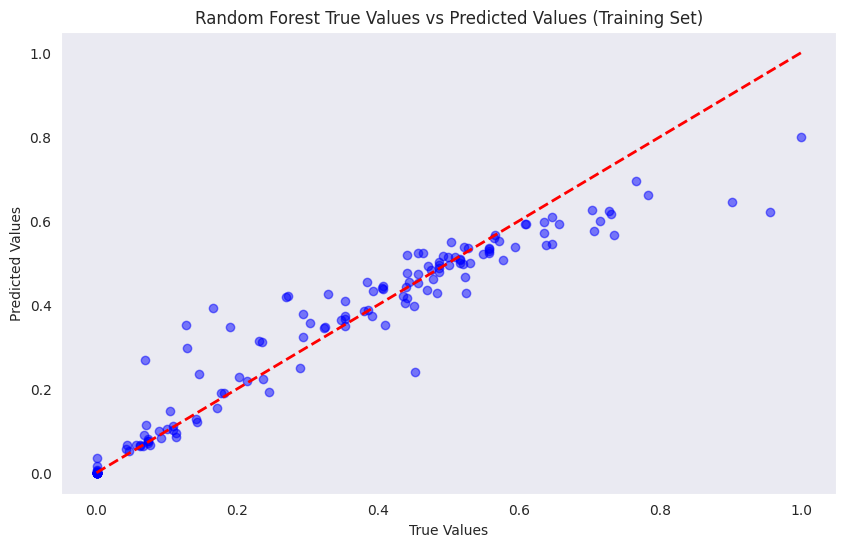

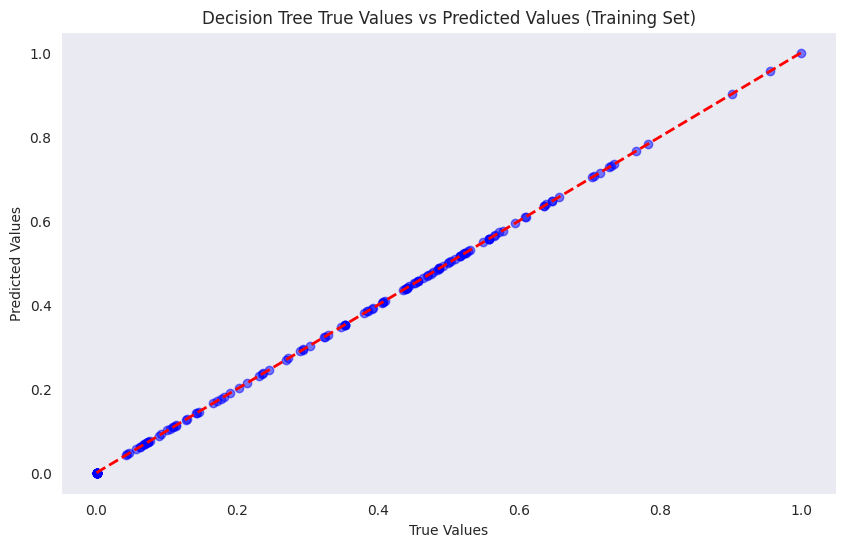

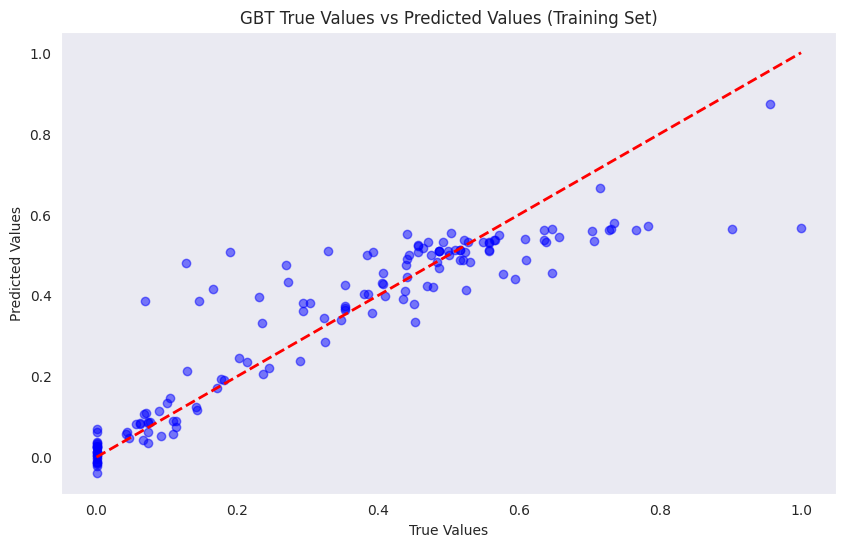

In [22]:
for name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_train_pred = model.predict(X_train_selected)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_train_pred, color='blue', alpha=0.5)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linewidth=2, linestyle='--')
    plt.title(f'{name} True Values vs Predicted Values (Training Set)')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.grid()
    plt.show()

相关性

/tmp/ipykernel_199114/3766585990.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


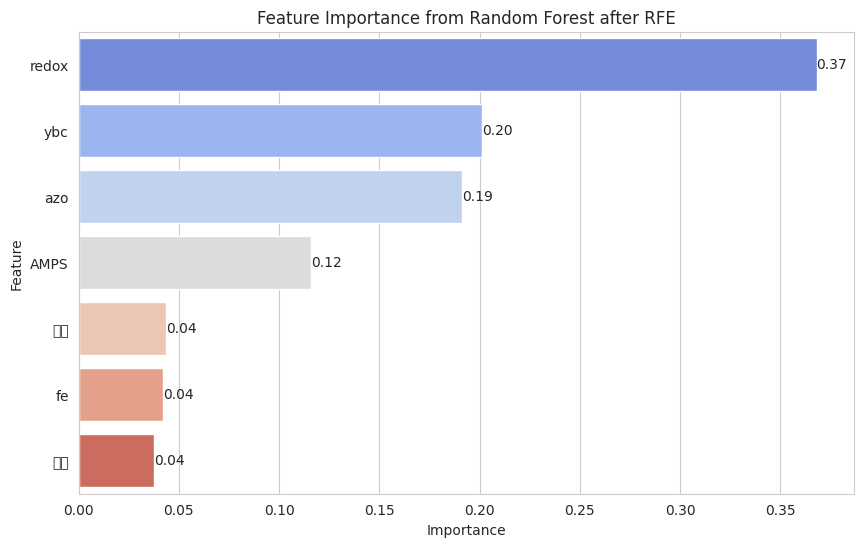

/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from c

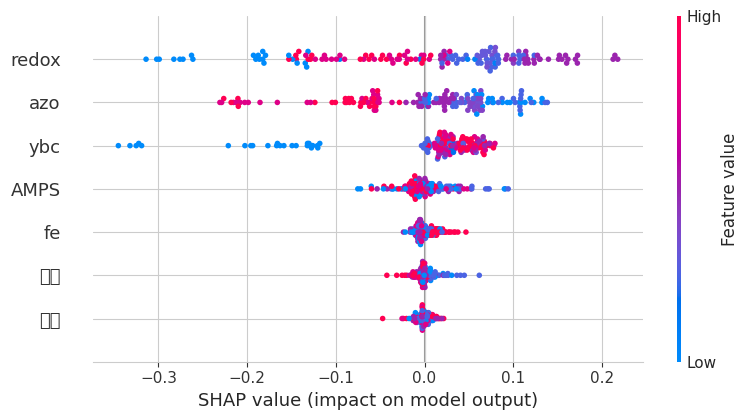

/tmp/ipykernel_199114/3766585990.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


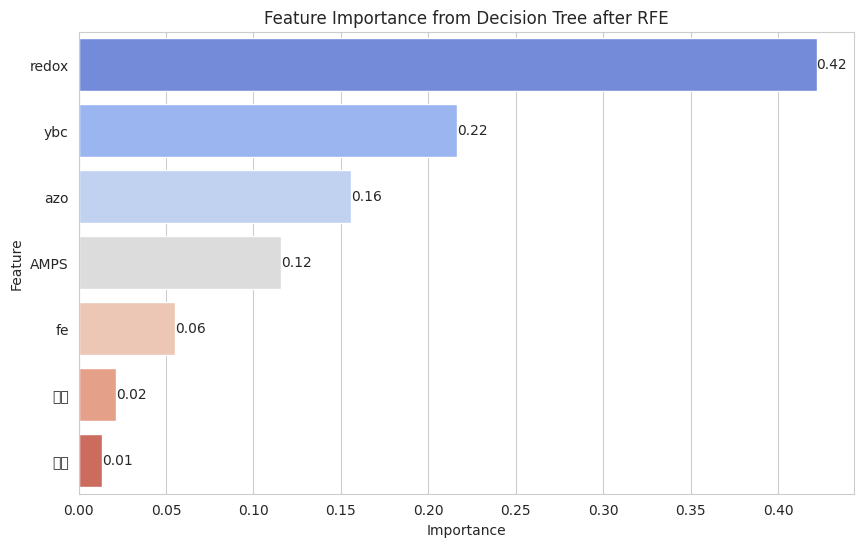

/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from c

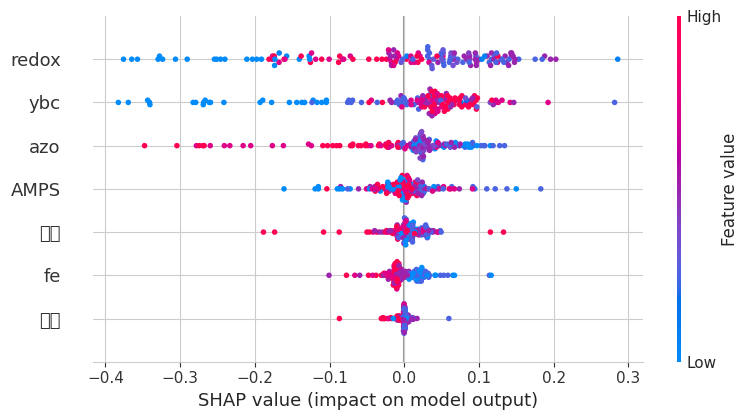

/tmp/ipykernel_199114/3766585990.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


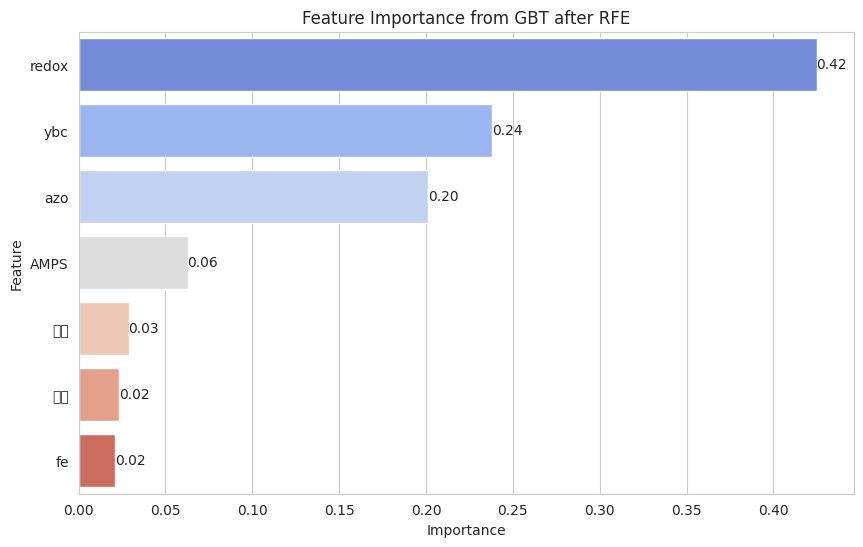

/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 27987 (\N{CJK UNIFIED IDEOGRAPH-6D53}) missing from current font.
  pl.tight_layout()
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 28201 (\N{CJK UNIFIED IDEOGRAPH-6E29}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/private/wuchenpeng/anaconda3/envs/DL/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from c

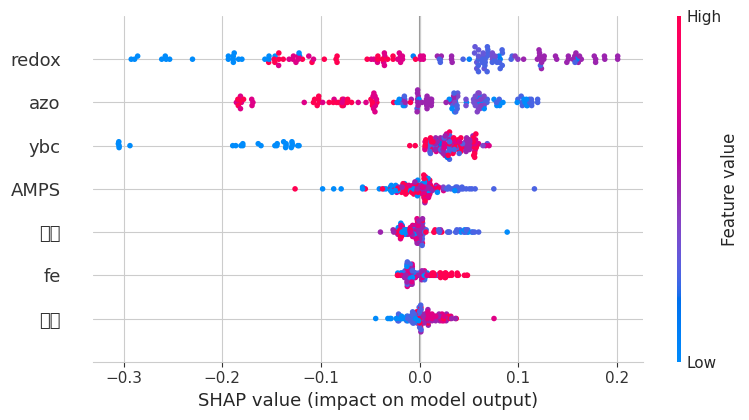

In [23]:
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体
model = {
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'GBT': GradientBoostingRegressor()
}

sel = selector.support_
# 创建特征名称列表
# fn = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', 'combined_feature', 'combined_feature1', 'combined_feature2']
fn = ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS']

sfn = [fn[i] for i, selected in enumerate(sel) if selected]

for name, mod in model.items():
    mod.fit(X_train_selected, y_train)
    # 获取选择后模型的特征重要性
    importances = mod.feature_importances_

    # 创建特征重要性 DataFrame
    feature_importance = pd.DataFrame({'Feature': sfn, 'Importance': importances})

    # 按照重要性降序排列
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='coolwarm')
    plt.title(f'Feature Importance from {name} after RFE')
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    # 在条形图上显示特征重要性的数值
    for index, value in enumerate(feature_importance['Importance']):
        plt.text(value, index, f'{value:.2f}', va='center')

    plt.show()

    explainer = shap.TreeExplainer(mod)
    shap_values = explainer.shap_values(X_train_selected)
    # shap_values_abs = np.abs(shap_values)

    # 绘制特征相关性的云图
    shap.summary_plot(shap_values, X_train, plot_type="dot")


In [55]:
# #打印所选特征
# selected_features = pd.Series(selector.support_, index=X_train.columns)
# selected_feature_names = selected_features[selected_features].index.tolist()
# print('Selected features:', selected_feature_names)

Selected features: ['redox', 'azo', 'fe', 'ybc', '温度', '浓度', 'AMPS', 'combined_feature', 'combined_feature1', 'combined_feature2']


In [154]:
# # 使用随机森林回归器
# rf_reg = RandomForestRegressor(n_estimators=90, random_state=42)
# rf_reg.fit(X_train_selected, y_train)
# y_pred = rf_reg.predict(X_test_selected)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print('Model performance (MSE, R2):', mse, r2)

Model performance (MSE, R2): 0.01915956553125595 0.7383153519281789


In [132]:
# # 不同算法对应的模型性能
# models = {
#     'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
#     'Linear Regression': LinearRegression(),
#     'SVR': SVR(),
#     'Decision Tree': DecisionTreeRegressor(random_state=42),
#     'GBT': GradientBoostingRegressor(n_estimators=100, random_state=42),
#     'XGBR':XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
# }

In [133]:
# # 测试不同模型
# for name, model in models.items():
#     model.fit(X_train_selected, y_train)
#     y_pred = model.predict(X_test_selected)
#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)
#     print(f'{name} performance (MSE, R2):', mse, r2)

Random Forest performance (MSE, R2): 0.019544474484431158 0.733058199108767
Linear Regression performance (MSE, R2): 0.05258792885855065 0.28174500440910033
SVR performance (MSE, R2): 0.02473982320397326 0.6620992309074333
Decision Tree performance (MSE, R2): 0.02489928664422866 0.6599212517577766
GBT performance (MSE, R2): 0.01855631025555934 0.7465547164513779
XGBR performance (MSE, R2): 0.023129881329738606 0.6840880944903731


In [31]:
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
# }
# grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=5)
# grid_search.fit(X_train_scaled, y_train)

KeyboardInterrupt: 

In [ ]:
# print('Best parameters:', grid_search.best_params_)